# Performance Python

It is a long-lived prejudice that Python is a relatively slow programming language and not appropriate to implement computationally demanding tasks in finance. Beyond the fact that Python is an interpreted language, the reasoning is usually along the following lines: Python is slow when it comes to loops; loops are often
required to implement financial algorithms; therefore Python is too slow for financial
algorithm implementation. 

Another line of reasoning is: other (compiled) programming languages are fast at executing loops (such as C or C++); loops are often required for financial algorithms; therefore these (compiled) programming languages are well suited for finance and financial algorithm implementation.

Admittedly, it is possible to write proper Python code that executes rather slowly—
perhaps too slowly for many application areas. This notebook is about approaches to
speed up typical tasks and algorithms often encountered in a financial context. It
shows that with a judicious use of data structures, choosing the right implementation
idioms and paradigms, as well as using the right performance packages, Python is
able to compete even with compiled programming languages. This is due to, among
other factors, getting compiled itself.
To this end, this chapter introduces different approaches to speed up code:

**Vectorization**
> Making use of Python’s vectorization capabilities is one approach already used
extensively in previous notebooks.

**Dynamic compiling**
> Using the Numba package allows one to dynamically compile pure Python code
using LLVM technology.

**Static compiling**
> Cython is not only a Python package but a hybrid language that combines Python
and C; it allows one, for instance, to use static type declarations and to statically
compile such adjusted code.

**Multiprocessing**
> The multiprocessing module of Python allows for easy and simple parallelization of code execution

## Python

In [2]:
import random

def average_py(n):
    total = 0
    for i in range(n):
        total += random.random() # Add the uniformly distributed random number to the total
    return total / n # Divide the total by the number of random numbers to get the average

n = 10000000
%time average_py(n)

CPU times: user 1.33 s, sys: 2.15 ms, total: 1.33 s
Wall time: 1.33 s


0.49987083609643596

In [3]:
%time sum([random.random() for _ in range(n)]) / n # Uses list comprehension instead of the function

CPU times: user 1.46 s, sys: 284 ms, total: 1.74 s
Wall time: 1.75 s


0.49996078211167827

## Numba


In [5]:
import numba

average_nb = numba.jit(average_py) # creates the numba function
%time average_nb(n) # The compiling happens during runtime, leading to some overhead

CPU times: user 373 ms, sys: 103 ms, total: 476 ms
Wall time: 426 ms


0.5000337804987515

In [6]:
%time average_nb(n)

CPU times: user 61.6 ms, sys: 180 µs, total: 61.7 ms
Wall time: 79.2 ms


0.5001633306913826

In [7]:
%time average_nb(n) # From the second execution, the execution is faster

CPU times: user 62 ms, sys: 0 ns, total: 62 ms
Wall time: 61.7 ms


0.5000652327775572

## NumPy

The strength of NumPy lies in its vectorization capabilities. Formally, loops vanish on
the Python level; the looping takes place one level deeper based on optimized and
compiled routines provided by NumPy.

The function average_np() makes use of this
approach:

In [8]:
import numpy as np

def average_np(n):
    s = np.random.random(n)
    return s.mean()

%time average_np(n)

CPU times: user 110 ms, sys: 1.77 ms, total: 112 ms
Wall time: 117 ms


0.500119481845839

In [9]:
%timeit average_np(n)

10 loops, best of 5: 104 ms per loop


In [10]:
s = np.random.random(n)
s.nbytes

80000000

The speedup is considerable, reaching almost a factor of 10 or an order of magnitude.
However, the price that must be paid is significantly higher memory usage. This is
due to the fact that NumPy attains speed by preallocating data that can be processed in
the compiled layer. As a consquence, there is no way, given this approach, to work
with “streamed” data. This increased memory usage might even be prohibitively large
depending on the algorithm or problem at hand.

## Cython

Cython allows one to statically compile Python code. However, the application is not
as simple as with Numba since the code generally needs to be changed to see signifi‐
cant speed improvements. To begin with, consider the Cython function aver
age_cy1(), which introduces static type declarations for the used variables:

In [11]:
%load_ext Cython

In [12]:
%%cython -a

import random
def average_cy1(int n):
    cdef int i 
    cdef float s = 0
    for i in range(n):
        s += random.random()
    return s / n

In [13]:
%timeit average_cy1(n)

1 loop, best of 5: 600 ms per loop


Some speedup is observed, but not even close to that achieved by, for example, the
NumPy version. A bit more Cython optimization is necessary to beat even the Numba
version:

In [14]:
%%cython
from libc.stdlib cimport rand

cdef extern from 'limits.h':
    int INT_MAX

cdef int i
cdef float rn
for i in range(5):
    rn = rand() / INT_MAX
    print(rn)

0.27777472138404846
0.5539699792861938
0.47739705443382263
0.6288709044456482
0.36478447914123535


In [15]:
%%cython -a
from libc.stdlib cimport rand

cdef extern from 'limits.h':
    int INT_MAX
 
def average_cy2(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += rand() / INT_MAX
    return s / n

In [16]:
%timeit average_cy2(n)

1 loop, best of 5: 204 ms per loop


This further optimized Cython version, average_cy2(), is now a bit faster than the
Numba version. However, the effort has also been a bit larger. Compared to the NumPy
version, Cython also preserves the memory efficiency of the original loop-based
implementation

# Algorithms
This section applies the performance-enhancing techniques from the previous section to some well-known problems and algorithms from mathematics. These algo‐
rithms are regularly used for performance benchmarks

## Prime Numbers
Prime numbers play an important role not only in theoretical mathematics but also
in many applied computer science disciplines, such as encryption. A prime number is
a positive natural number greater than 1 that is only divisible without remainder by 1
and itself. There are no other factors. While it is difficult to find larger prime num‐
bers due to their rarity, it is easy to prove that a number is not prime. The only thing
that is needed is a factor other than 1 that divides the number without a remainder.

### Python


In [17]:
def is_prime(I):
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

n = int(1e8 + 3)
n

100000003

In [18]:
%time is_prime(n)

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 36.7 µs


False

In [19]:
pi = int(1e8 + 7)
pi

100000007

In [20]:
%time is_prime(pi)

CPU times: user 807 µs, sys: 0 ns, total: 807 µs
Wall time: 813 µs


True

In [21]:
p2 = 100109100129162907 
p2.bit_length()

57

In [22]:
%time is_prime(p2)

CPU times: user 18.9 s, sys: 27.7 ms, total: 18.9 s
Wall time: 19 s


True

### Numba

In [23]:
import numba
is_prime_nb = numba.jit(is_prime)

In [24]:
%time is_prime_nb(n)

CPU times: user 145 ms, sys: 982 µs, total: 145 ms
Wall time: 151 ms


False

In [26]:
%time is_prime_nb(pi) # From the second call, the speedup becomes fully visible

CPU times: user 64 µs, sys: 2 µs, total: 66 µs
Wall time: 72.5 µs


True

In [27]:
%time is_prime_nb(p2) # The speedup for the larger prime is about an order of magnitude

CPU times: user 1.83 s, sys: 6.99 ms, total: 1.84 s
Wall time: 1.83 s


True

### Cython
The application of Cython is straightforward as well. A plain Cython version without
type declarations already speeds up the code significantly:

In [30]:
%%cython
def is_prime_cy(I):
  if I % 2 == 0: return False
  for i in range(3, int(I ** 0.5) + 1, 2):
    if I % i == 0: return False
  return True

In [32]:
%timeit is_prime(pi)

1000 loops, best of 5: 371 µs per loop


In [33]:
%timeit is_prime_cy(pi)

The slowest run took 5.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 199 µs per loop


In [35]:
# However, real improvements only materialize with the static
# type declarations.
%%cython 
def is_prime_cy2(long I):
  cdef long i
  if I % 2 == 0: return False
  for i in range(3, int(I ** 0.5) + 1, 2):
    if I % i == 0: return False
  return True

In [36]:
%timeit is_prime_cy2(pi)

The slowest run took 256.03 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 55.9 µs per loop


In [37]:
%time is_prime_nb(p2)

CPU times: user 1.8 s, sys: 6.99 ms, total: 1.81 s
Wall time: 1.8 s


True

In [38]:
%time is_prime_cy2(p2)

CPU times: user 1.81 s, sys: 9.95 ms, total: 1.82 s
Wall time: 1.81 s


True

### Multiprocessing

So far, all the optimization efforts have focused on the sequential code execution. In
particular with prime numbers, there might be a need to check multiple numbers at
the same time. To this end, the multiprocessing module can help speed up the code
execution further. It allows one to spawn multiple Python processes that run in paral‐
lel. The application is straightforward in the simple case at hand. First, an mp.Pool
object is set up with multiple processes. Second, the function to be executed is map‐
ped to the prime numbers to be checked:

In [39]:
import multiprocessing as mp

pool = mp.Pool(processes=4)

%time pool.map(is_prime, 10 * [pi])

CPU times: user 0 ns, sys: 1.39 ms, total: 1.39 ms
Wall time: 6.8 ms


[True, True, True, True, True, True, True, True, True, True]

In [40]:
%time pool.map(is_prime_nb, 10 * [p2])

CPU times: user 101 ms, sys: 25.4 ms, total: 126 ms
Wall time: 16.7 s


[True, True, True, True, True, True, True, True, True, True]

In [41]:
%time pool.map(is_prime_cy2, 10 * [p2])

CPU times: user 97.2 ms, sys: 7.32 ms, total: 105 ms
Wall time: 15.8 s


[True, True, True, True, True, True, True, True, True, True]

The observed speedup is significant. The Python function is_prime() takes more
than 20 seconds for the larger prime number p2. Both the is_prime_nb() and the
is_prime_cy2() functions take less than 10 seconds for 10 times the prime number
p2 when executed in parallel with four processes

## Fibonacci Numbers

Fibonacci numbers and sequences can be derived based on a simple algorithm. Start
with two ones: 1, 1. From the third number, the next Fibonacci number is derived as
the sum of the two preceding ones: 1, 1, 2, 3, 5, 8, 13, 21, …. . This section analyzes two
different implementations, a recursive one and an iterative one.

### Recursive algorithm

Similar to regular Python loops, it is known that regular recursive function imple‐
mentations are relatively slow with Python. Such functions call themselves potentially
a large number of times to come up with the final result. The function
fib_rec_py1() presents such an implementation. In this case, Numba does not help at
all with speeding up the execution. However, Cython shows significant speedups
based on static type declarations only:

In [42]:
def fib_rec_py1(n):
  if n < 2:
    return n
  else:
    return fib_rec_py1(n - 1) + fib_rec_py1(n - 2)

%time fib_rec_py1(35)

CPU times: user 3.96 s, sys: 16.4 ms, total: 3.98 s
Wall time: 3.98 s


9227465

In [ ]:
fib_rec_nb = numba.jit(fib_rec_py1)
%time fib_rec_nb(35)

In [46]:
%%cython
def fib_rec_cy(int n):
  if n < 2:
    return n
  else:
    return fib_rec_cy(n - 1) + fib_rec_cy(n - 2)

In [47]:
%time fib_rec_cy(35)

CPU times: user 796 ms, sys: 5.91 ms, total: 802 ms
Wall time: 802 ms


9227465

The major problem with the recursive algorithm is that intermediate results are not
cached but rather recalculated. To avoid this particular problem, a decorator can be
used that takes care of the caching of intermediate results. This speeds up the execu‐
tion by multiple orders of magnitude:

In [48]:
from functools import lru_cache as cache

@cache(maxsize=None)
def fib_rec_py2(n):
  if n < 2:
    return n
  else:
    return fib_rec_py2(n - 1) + fib_rec_py2(n - 2)

In [49]:
%time fib_rec_py2(35)

CPU times: user 43 µs, sys: 2 µs, total: 45 µs
Wall time: 47.9 µs


9227465

In [50]:
%time fib_rec_py2(80)

CPU times: user 48 µs, sys: 2 µs, total: 50 µs
Wall time: 53.4 µs


23416728348467685

### Iterative Algorithm

Although the algorithm to calculate the nth Fibonacci number can be implemented
recursively, it doesn’t have to be. The following presents an iterative implementation
which is even in pure Python faster than the cached variant of the recursive
implementation. This is also the terrain where Numba leads to further improvements.
However, the Cython version comes out as the winner:

In [51]:
def fib_it_py(n):
  x, y = 0, 1
  for i in range(1, n + 1):
    x, y = y, x + y
  return x

In [52]:
%time fib_it_py(80)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15 µs


23416728348467685

In [53]:
fib_it_nb = numba.jit(fib_it_py)

In [54]:
%time fib_it_nb(80)

CPU times: user 82.4 ms, sys: 921 µs, total: 83.3 ms
Wall time: 85.7 ms


23416728348467685

In [55]:
%%cython
def fib_it_cy1(int n):
  cdef long i
  cdef long x = 0, y = 1
  for i in range(1, n + 1):
    x, y = y, x + y
  return x

In [56]:
%time fib_it_cy1(80)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


23416728348467685

Now that everything is so fast, one might wonder why we’re just calculating the 80th
Fibonacci number and not the 150th, for instance. The problem is with the available
data types. While Python can basically handle arbitrarily large numbers this is not true in general for the compiled languages. With
Cython one can, however, rely on a special data type to allow for numbers larger than
the double float object with 64 bits allows for:

In [57]:
%%time
fn = fib_rec_py2(150)
print(fn)

9969216677189303386214405760200
CPU times: user 244 µs, sys: 0 ns, total: 244 µs
Wall time: 251 µs


In [58]:
fn.bit_length()

103

In [59]:
%%time
fn = fib_it_nb(150)
print(fn)

6792540214324356296
CPU times: user 2.06 ms, sys: 0 ns, total: 2.06 ms
Wall time: 7.72 ms


In [60]:
fn.bit_length()

63

In [61]:
%%cython
cdef extern from *:
  ctypedef int int128 '__int128_t'
def fib_it_cy2(int n):
  cdef int128 i
  cdef int128 x = 0, y = 1
  for i in range(1, n + 1):
    x, y = y, x + y
  return x

In [63]:
%%time
fn = fib_it_cy2(150)
print(fn) 

9969216677189303386214405760200
CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 2.36 ms


## The Number Pi

The final algorithm analyzed in this section is a Monte Carlo simulation–based algorithm to derive digits for the number pi (π). The basic idea relies on the fact that the
area A of a circle is given by $A = πr
^2$
. Therefore, $π=A/r^2$. For a unit circle with radius
r = 1, it holds that π = A. The idea of the algorithm is to simulate random points with
coordinate values (x, y), with x, y ∈ [–1, 1]. The area of an origin-centered square
with side length of 2 is exactly 4. The area of the origin-centered unit circle is a frac‐
tion of the area of such a square. This fraction can be estimated by Monte Carlo sim‐
ulation: count all the points in the square, then count all the points in the circle, and
divide the number of points in the circle by the number of points in the square. The
following example demonstrates 

In [65]:
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [66]:
rn = [(random.random() * 2 - 1, random.random() * 2 -1) for _ in range(500)]
rn = np.array(rn)
rn[:5]

array([[-0.93658333,  0.39458646],
       [ 0.99281422, -0.2182959 ],
       [-0.46106045,  0.58733934],
       [ 0.71295701, -0.7133894 ],
       [-0.22224669,  0.6709082 ]])

(-1.1, 1.1)

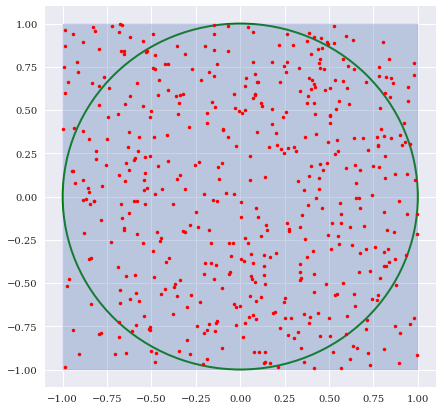

In [67]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='g', lw=2.0,
facecolor='None')
box = plt.Rectangle((-1, -1), 2, 2, edgecolor='b', alpha=0.3)
ax.add_patch(circ)
ax.add_patch(box)
plt.plot(rn[:, 0], rn[:, 1], 'r.')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)